In [1]:
!pip3 install numpy
!pip3 install pandas
!pip3 install scipy
!pip3 install matplotlib

In [2]:
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
import datetime
import re

In [4]:
with open('../data/Post-Fayetville.txt', encoding="utf8") as f:
    data = f.read().lower()
# print(data)

In [5]:
def preprocess(text):
    pattern = r'\(-(\d+)%\)'
    # First, make initial replacements for specific words with hyphens
    text = text.replace('t-spine', 't spine')
    text = text.replace('ez-bar', 'ez bar')
    text = text.replace('single-arm', 'single arm')
    text = text.replace('straight-bar', 'straight bar')
    text = text.replace('snatch-grip', 'snatch grip')
    text = text.replace('single-legged', 'single legged')
    text = text.replace('straight-bar', 'straight bar')
    text = text.replace('close-grip', 'close grip')
    text = text.replace('backoffs', '')
    text = text.replace('paused', 'pause')
    text = text.replace('bench press', 'bench')
    text = text.replace('ohp', 'military press')
    text = text.replace('high bar squat', 'high bar')
    text = text.replace('neutral grip lat pulldown', 'lat pulldown')
    text = text.replace('neutral lat pulldown', 'lat pulldown')
    text = text.replace('close grip lat pulldown', 'lat pulldown')
    text = text.replace('v-bar', 'v bar')
    text = text.replace('pull-ups', 'pull ups')
    text = text.replace('t-bar', 't bar')
    text = text.replace('bw', '0')
    text = text.replace('closer grip bench', 'close grip bench')
    text = text.replace('closer bench', 'close grip bench')
    text = text.replace('rows', 'row')
    text = re.sub(pattern, '', text)
    
    
    # Split the text into lines
    lines = text.split('\n')
    
    # Process each line to replace dashes after the first two
    new_lines = []
    for line in lines:
        parts = line.split('-')
        if len(parts) > 2:
            # Join the first two parts with a dash, and the rest with a slash
            new_line = '-'.join(parts[:2]) + '-' + '/'.join(parts[2:])
        else:
            # No need to replace if there are not more than two parts
            new_line = '-'.join(parts)
        new_lines.append(new_line)
    
    # Return the modified lines joined back into a single string
    return '\n'.join(new_lines)

In [6]:
processed_data = preprocess(data)
print(processed_data)

2020 post-fayetteville training
5/3/20
dawson warmup
pause comp squat - 315x3x3@6 - right on target with rpe, trying to engage upper back and evenly descent as much as possible, pause needs to be longer next week
comp bench - 285x1@8 - true 8, shoulder irritated from different warmups but will fix in future
close grip bench  - 225x3x6@6 - great starting point, focus on upper back tightness, right on target rpe 
rope bicep curl - 52.5x4x10
rope tricep extensions - 47.5x4x12
dumbbell shoulder press - 40x4x10
side lateral raise - 15x4x10 
rear delt flys - 70x4x12 
5/4/20
dawson warmup, add goblet squats next time
comp squat - 425x1@6, 375x4x5@7 - single was right on target, keep the same back position throughout, more upright position is necessary to stay over midfoot, slight right quad irritation from now doing a type of squat in warmup, last set rpe 7
leg extension - 70x4x12
hip adductor - 210x4x20
hip abductor - 210x4x15
5/5/20
dawson warmup + goblet squats 
comp deadlift - 495x3@7, 43

In [7]:
def validate(date_text):
    try:
        # Parse date checks if it's a valid date in the MM/DD/YY format
        datetime.datetime.strptime(date_text, '%m/%d/%y')
        return True
    except ValueError:
        return False

In [8]:
print(validate('1/13/20'))
print(validate('Test'))

True
False


In [9]:
def dynamic_transform_weights(weight_string):
    # Split the string into parts based on commas to handle multiple weights
    weight_parts = [part.strip() for part in weight_string.split(',')]

    # Initialize a list to hold transformed parts
    transformed_parts = []

    # Check the format of the last part to determine if it dictates shared repetitions
    last_part_components = weight_parts[-1].split('x')

    # Check if shared repetitions should be applied
    if len(last_part_components) == 2 and last_part_components[1].isdigit() and all('x' not in part for part in weight_parts[:-1]):
        # The last part indicates shared repetitions across weights
        reps = last_part_components[1]
        for part in weight_parts[:-1]:
            transformed_parts.append(f"{part}x{reps}")
        # Include the last weight with the shared reps
        last_weight = last_part_components[0]
        transformed_parts.append(f"{last_weight}x{reps}")
    else:
        # No shared repetitions, output each part as is
        transformed_parts = weight_parts

    return ', '.join(transformed_parts)

In [10]:
print(dynamic_transform_weights('395,410,455x3'))        # Expected = 395x3, 410x3, 455x3
print(dynamic_transform_weights('410x3x3'))              # Expected = 410x3x3
print(dynamic_transform_weights('365x2x6,315x6@6'))      # Expected = 365x2x6,315x6@6
print(dynamic_transform_weights('45x15, 95x10, 135x8, \
                                185x5, 225x1, \
                                235x3, 242.5x3,250x3'))  # Expected = 45x15, 95x10, 135x8, 185x5, 225x1, 235x3, 242.5x3, 250x3

395x3, 410x3, 455x3
410x3x3
365x2x6, 315x6@6
45x15, 95x10, 135x8, 185x5, 225x1, 235x3, 242.5x3, 250x3


In [11]:
def parse_exercise_data(data):
    # Initialize lists to store weights, sets, reps, and optionally RPE
    weights = []
    sets = []
    reps = []
    rpes = []  # List to store RPE values

    # Iterate over each sublist in the main list
    for sublist in data:
        for item in sublist:
            # Clean up any leading/trailing whitespace
            item = item.strip()

            # Handle RPE if present
            if '@' in item:
                item, rpe = item.split('@')
                rpes.append(float(rpe))  # Convert RPE to float in case of decimal RPE values
            else:
                rpes.append(None)  # Append None when RPE is not specified

            # Split the string at 'x' to extract components
            parts = item.split('x')

            # Determine how to parse the item based on the number of parts found
            if len(parts) == 3:
                weights.append(float(parts[0]))
                sets.append(int(parts[1]))
                reps.append(int(parts[2]))
            elif len(parts) == 2:
                weights.append(float(parts[0]))
                sets.append(1)  # Default value for sets
                reps.append(int(parts[1]))
            elif len(parts) == 1 and parts[0].replace('.', '', 1).isdigit():
                # Handle numeric input as weights with default sets and reps
                weights.append(float(parts[0]))
                sets.append(1)  # Default sets
                reps.append(1)  # Default reps
            else:
                # Log unexpected formats
                print(f"Unexpected format: {item}")

    return weights, sets, reps, rpes

In [12]:
print(parse_exercise_data([['245x6', ' 225x2x6']]))
print(parse_exercise_data([['585x1@9']]))

([245.0, 225.0], [1, 2], [6, 6], [None, None])
([585.0], [1], [1], [9.0])


In [13]:
lines = processed_data.strip().split('\n')
workout_log = {}
current_date = None

for line in lines:
    if validate(line):
        current_date = line
        workout_log[current_date] = []
    elif current_date:
        workout_log[current_date].append(line.strip())

# Data structure to load into DataFrame
df_data = []
something = []

for date, contents in workout_log.items():
    for content in contents:
        # print(contents[0])
        items = content.split('-')
        if len(items) >= 3:  # Ensure there are enough parts
            exercise = items[0].strip()
            weights_sets_reps = dynamic_transform_weights(items[1].strip()).split(sep=',')
            notes = '-'.join(items[2:]).strip()  # Join any remaining parts as notes
            weights, sets, reps, rpe = (parse_exercise_data(([weights_sets_reps])))
            df_data.append([date, exercise, weights, sets, reps, rpe, contents[0], notes])

In [14]:
df = pd.DataFrame(df_data, columns=["Date", "Exercise", "Weights", "Sets", "Reps", "RPE", "Mobility", "Notes"])

In [15]:
df['Exercise'].unique()

array(['pause comp squat', 'comp bench', 'close grip bench', 'comp squat',
       'comp deadlift', 'high bar', 'beltless conventional deadlift',
       'machine chest flys', 'pull ups', 'rear delt flys', 't bar row',
       'conventional deadlift', 'ssb squat', 'dumbbell rdl', 'belt squat',
       'db flys', 'larsen press', 'beltless comp deadlift',
       'flat dumbbell bench', 'pause comp deadlift',
       '3:1:0 tempo comp bench', 'single arm t bar row',
       'flat dumbbell feet up bench', 'candito deadlift', 'spoto press',
       'goblet split squats', '3:1:0 tempo bench'], dtype=object)

In [16]:
df.head(100)

,Date,Exercise,Weights,Sets,Reps,RPE,Mobility,Notes
0,5/3/20,pause comp squat,[315.0],[3],[3],[6.0],dawson warmup,"right on target with rpe, trying to engage upp..."
1,5/3/20,comp bench,[285.0],[1],[1],[8.0],dawson warmup,"true 8, shoulder irritated from different warm..."
2,5/3/20,close grip bench,[225.0],[3],[6],[6.0],dawson warmup,"great starting point, focus on upper back tigh..."
3,5/4/20,comp squat,"[425.0, 375.0]","[1, 4]","[1, 5]","[6.0, 7.0]","dawson warmup, add goblet squats next time","single was right on target, keep the same back..."
4,5/5/20,comp deadlift,"[495.0, 435.0]","[1, 3]","[3, 5]","[7.0, 6.0]",dawson warmup + goblet squats,"top triple was right on rpe, were fine rpe bu..."
...,...,...,...,...,...,...,...,...
95,7/31/20,comp bench,"[280.0, 265.0, 250.0, 240.0]","[1, 1, 2, 2]","[1, 3, 2, 3]","[6.0, 6.0, None, None]",10min bike warmup,every set felt very technically solid
96,8/1/20,high bar,"[385.0, 335.0]","[1, 3]","[1, 4]","[6.0, 6.0]","10min bike ride 64cal, mobility, warmup",easy just hurts as a third day
97,8/1/20,comp deadlift,"[445.0, 455.0, 455.0, 460.0, 460.0]","[1, 1, 1, 1, 1]","[1, 1, 1, 1, 1]","[None, None, None, None, None]","10min bike ride 64cal, mobility, warmup","all fucking easy, wedging is best it’s ever be..."
98,8/1/20,close grip bench,[235.0],[1],[7],[5.0],"10min bike ride 64cal, mobility, warmup","6, 215x2x6 / extremely smooth and easy"


In [17]:
df1 = df[df['Exercise'].str.contains('comp bench')]
df1

,Date,Exercise,Weights,Sets,Reps,RPE,Mobility,Notes
1,5/3/20,comp bench,[285.0],[1],[1],[8.0],dawson warmup,"true 8, shoulder irritated from different warm..."
5,5/5/20,comp bench,[240.0],[4],[5],[7.0],dawson warmup + goblet squats,"right on rpe target, fatigue made back positio..."
8,5/7/20,comp bench,"[315.0, 275.0]","[1, 5]","[1, 2]","[9.0, 8.0]",no mobility,"single was so much smoother than my last 315, ..."
11,5/8/20,comp bench,[245.0],[3],[3],[6.0],"foam rolling, mobility, warmup","easy money, sore af tho"
14,5/11/20,comp bench,"[295.0, 320.0]","[1, 1]","[1, 1]","[7.0, 10.0]","foam rolling, warmup, mobility","nice pr and was clean, 295 was @7, strength tr..."
19,5/13/20,comp bench,[250.0],[4],[4],[7.0],"foam rolling, mobility, warmup",right on target rpe
22,5/15/20,comp bench,"[305.0, 280.0]","[1, 5]","[1, 2]","[8.0, 8.0]","foam rolling, mobility, warmup","single was right on target, no pain on anythin..."
25,5/16/20,comp bench,[245.0],[3],[3],[6.0],"foam rolling, mobility, warmup",right at prescribed rpe
27,5/18/20,comp bench,[295.0],[1],[1],[8.0],"foam rolling, mobility, warmup","pec and shoulder felt terrible, need to rearra..."
30,5/21/20,comp bench,"[305.0, 325.0, 290.0, 280.0]","[1, 1, 2, 2]","[1, 1, 2, 2]","[9.0, 10.0, 9.0, 8.0]",warmup,slight overshoot on but very nice increase


C:\Users\Grant\AppData\Local\Temp\ipykernel_14784\935518174.py:46: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dates = pd.to_datetime(dates)
C:\Users\Grant\AppData\Local\Temp\ipykernel_14784\935518174.py:48: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dates2 = pd.to_datetime(dates2)


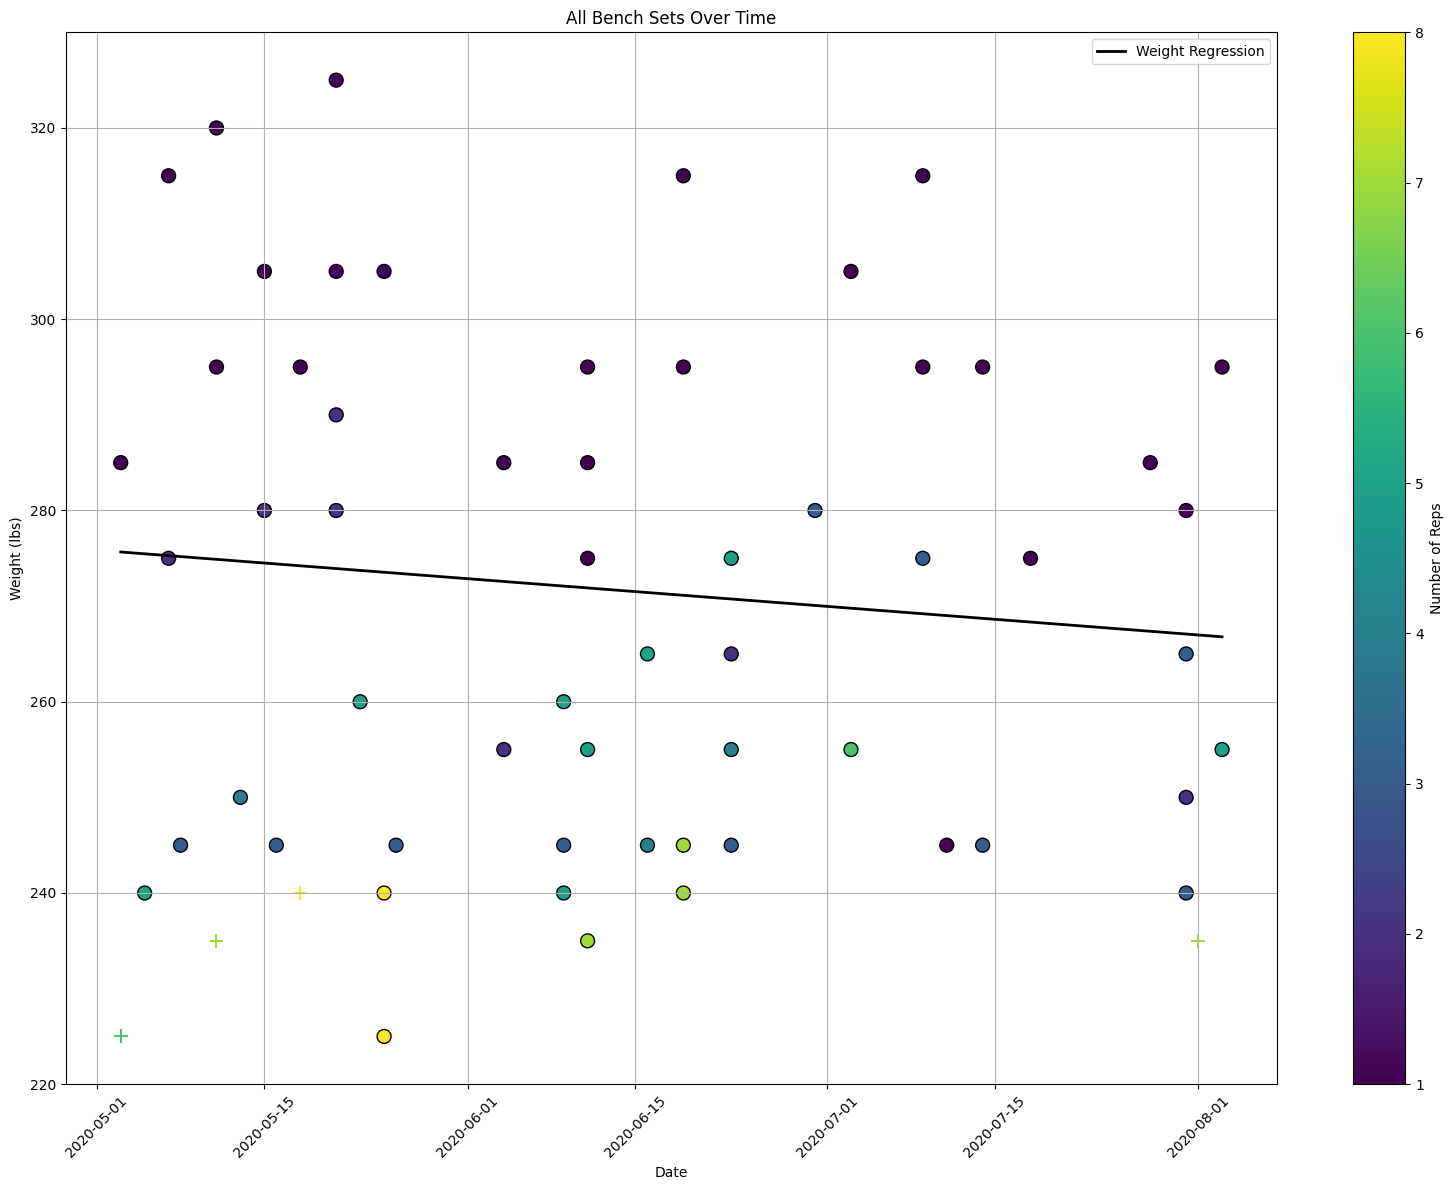

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.dates import date2num


# Filter the DataFrame for 'bench' related exercises, assuming all variations contain "comp bench"
df1 = df[df['Exercise'] == 'comp bench']
df2 = df[df['Exercise'] == 'close grip bench']

# Prepare lists to store plot data
dates = []
weights = []
reps = []

dates2 = []
weights2 = []
reps2 = []

# print(bench_df)
# bench_df = bench_df.explode('Weights').explode('Reps')
# print(bench_df)

# filtered_df = bench_df[(bench_df['Weights'] > 150) & (bench_df['Reps'] > 0)]

# result_df = filtered_df.groupby('Date')['Weights'].max().reset_index()
# print(result_df)
# Iterate over the filtered DataFrame
for index, row in df1.iterrows():
    # Check each weight and corresponding rep count
    for weight, rep in zip(row['Weights'], row['Reps']):
        if rep > 0 and weight > 150:  # Only consider reps greater than zero
            dates.append(row['Date'])
            weights.append(weight)
            reps.append(rep)

# Iterate over the filtered DataFrame
for index, row in df2.iterrows():
    # Check each weight and corresponding rep count
    for weight, rep in zip(row['Weights'], row['Reps']):
        dates2.append(row['Date'])
        weights2.append(weight)
        reps2.append(rep)

# Convert dates for plotting
dates = pd.to_datetime(dates)
# print('before', inclineDates)
dates2 = pd.to_datetime(dates2)
# print('after', inclineDates)
date_nums = date2num(dates)  # Convert dates to ordinal numbers for regression

# Use a colormap to vary colors based on the number of reps
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(min(reps), max(reps))

# linear regression line
slope, intercept = np.polyfit(date_nums, weights, 1)
regression_line = slope * date_nums + intercept

# Plotting
plt.figure(figsize=(16, 12))
scatter = plt.scatter(dates, weights, c=reps, cmap=cmap, norm=norm, s=100, edgecolor='k')
plt.plot(dates, regression_line, color='black', linewidth=2, label='Weight Regression')  # Add regression line
plt.scatter(dates2, weights2, c=reps2, cmap=cmap, norm=norm, s=100, marker='+')
plt.title('All Bench Sets Over Time')
plt.xlabel('Date')
plt.ylabel('Weight (lbs)')
plt.colorbar(scatter, label='Number of Reps')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()

In [19]:
df.to_csv("../processed_data/Post-Fayetville_Data.csv")